In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from HMC_new import HMC

2022-02-28 17:44:21.456938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 17:44:21.476739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 17:44:21.476880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 17:44:21.477414: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

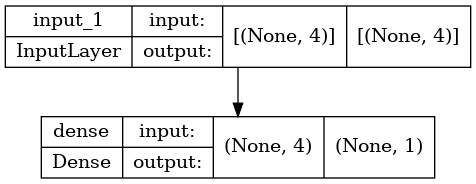

In [2]:
# Creating basic keras model
model = keras.Sequential([
    keras.Input(shape=(4,)),
    # keras.layers.Dense(8, activation="relu", kernel_regularizer=tf.keras.regularizers.L1(1)),
    keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L1(0.1), use_bias=False)
])
model.compile(optimizer=keras.optimizers.Adam(1e-2),
              loss=keras.losses.MeanSquaredError())
keras.utils.plot_model(model, show_shapes=True, to_file="../etc/test.png")

In [3]:
# creating fake data
t = np.linspace(-3.14, 3.14, 50)
x = np.stack([
    t ** 2,
    t,
    np.cos(t),
    - t ** 3
]).T + 0 * np.random.randn(50, 4)
y = np.expand_dims(t, axis=1)

(50, 4)


In [4]:
# model pre-training
model.fit(x, y, epochs=500)

Epoch 1/500
2/2 [==============================] - 0s 2ms/step - loss: 23.5267
Epoch 2/500
2/2 [==============================] - 0s 1ms/step - loss: 20.8414
Epoch 3/500
2/2 [==============================] - 0s 2ms/step - loss: 18.6262
Epoch 4/500
2/2 [==============================] - 0s 1ms/step - loss: 16.4225
Epoch 5/500
2/2 [==============================] - 0s 2ms/step - loss: 14.5028
Epoch 6/500
2/2 [==============================] - 0s 2ms/step - loss: 12.4167
Epoch 7/500
2/2 [==============================] - 0s 4ms/step - loss: 10.8223
Epoch 8/500
2/2 [==============================] - 0s 2ms/step - loss: 9.4367
Epoch 9/500
2/2 [==============================] - 0s 1ms/step - loss: 7.9973
Epoch 10/500
2/2 [==============================] - 0s 1ms/step - loss: 6.9244
Epoch 11/500
2/2 [==============================] - 0s 1ms/step - loss: 5.6623
Epoch 12/500
2/2 [==============================] - 0s 1ms/step - loss: 4.9190
Epoch 13/500
2/2 [==============================] - 0s

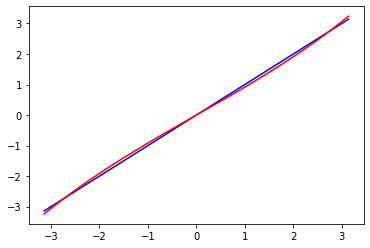

[<tf.Variable 'dense/kernel:0' shape=(4, 1) dtype=float32, numpy=
 array([[-6.9722577e-05],
        [ 9.0351588e-01],
        [-2.6005227e-04],
        [-1.2941700e-02]], dtype=float32)>]

In [5]:
# plot fitted prediction and model pre-trained parameters
fig = plt.figure()
plt.plot(t, y, 'b-')
plt.plot(t, model(x), 'r-')
plt.show()
model.trainable_variables

In [6]:
# Create HMC super-model
hmc = HMC(model, L=10, epsilon=1e-2, batch_size=50)

# Initialize bookkeeping
n_iter = 2000
parameters = np.zeros((n_iter, hmc.param_num), dtype=np.float32)  # bookkeeping the parameters
log_gamma = np.zeros((n_iter,), dtype=np.float32)  # bookkeeping the loggamma
log_lambda = np.zeros((n_iter,), dtype=np.float32)  # bookkeeping the loggamma
log_likelihood = np.zeros((n_iter,), dtype=np.float32)  # bookkeeping the loggamma
hamiltonians = np.zeros((n_iter,), dtype=np.float32)
acceptance = np.zeros((n_iter,), dtype=np.float32)

# training loop
for step in range(n_iter):
    new_state, loss, p, accepted, h = hmc((x, y))
    # print(f"Step {step}: ")
    if accepted:
        acceptance[step] = 1
        # print(f"New state accepted with probability {p}")
    # else:
    # print(f"New state rejected with probability {p}")

    # bookkeeping
    parameters[step, :] = new_state.position
    log_gamma[step] = new_state.log_gamma
    log_lambda[step] = new_state.log_lambda
    log_likelihood[step] = loss
    hamiltonians[step] = h

In [7]:
# Computing MAP estimate
idx_MAP = np.argmin(log_likelihood)
MAP = parameters[idx_MAP, :]
hmc.set_model_params(MAP)
y_MAP = hmc.model(x)

# preparing sampling
precision = np.exp(log_gamma)
num_dim = 1
n_samples = 500
trajectories = np.zeros((50, num_dim, n_samples))
sigma_normal = np.std(y)

# sampling
for k in range(n_samples):
    idx_1 = np.random.randint(0, n_iter - 1)
    idx_2 = np.random.randint(0, n_iter - 1)
    w_sample = parameters[-idx_1, :]
    precision_here = precision[-idx_2] * num_dim
    hmc.set_model_params(w_sample)
    trajectories[:, :, k] = hmc.model(x) + sigma_normal * np.random.normal() / np.sqrt(precision_here)

mu_pred = np.mean(trajectories, axis=2)
sigma_pred = np.var(trajectories, axis=2)

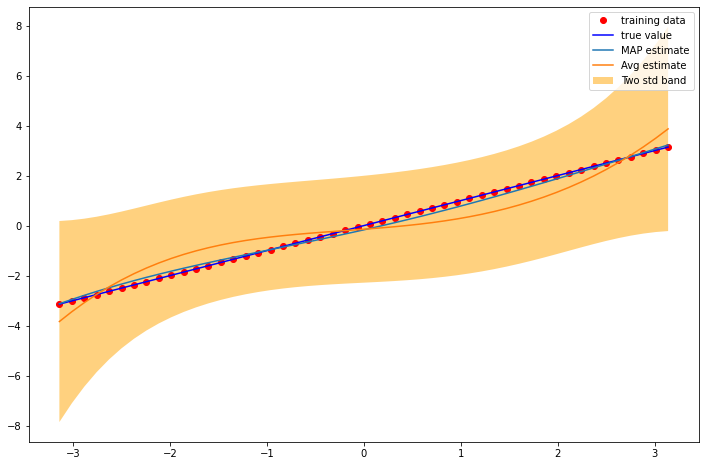

array([-0.0119963 ,  0.8722772 , -0.16932154, -0.01406069], dtype=float32)

In [11]:
# plot results and display MAP parameters
plt.figure(figsize=(12, 8))
plt.plot(t, y, 'ro', label="training data")
plt.plot(t, y, 'b-', label="true value")
plt.plot(t, y_MAP, label="MAP estimate")
plt.plot(t, mu_pred, label="Avg estimate")
lower = mu_pred[:, 0] - 2 * np.sqrt(sigma_pred[:, 0])
upper = mu_pred[:, 0] + 2 * np.sqrt(sigma_pred[:, 0])
plt.fill_between(t, lower, upper, facecolor="orange", alpha=0.5, label="Two std band")
plt.legend()
plt.show()
MAP

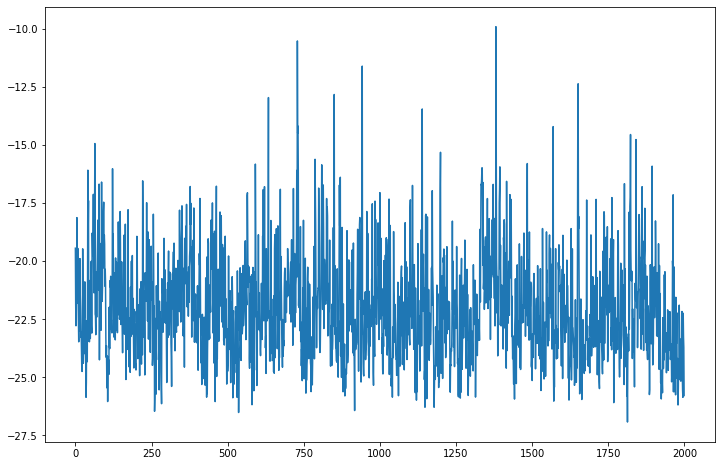

In [12]:
# Plot Hamiltonian variation through trajectory (approximately constant in theory)
plt.figure(figsize=(12,8))
plt.plot(range(hamiltonians.size), hamiltonians)
plt.show()

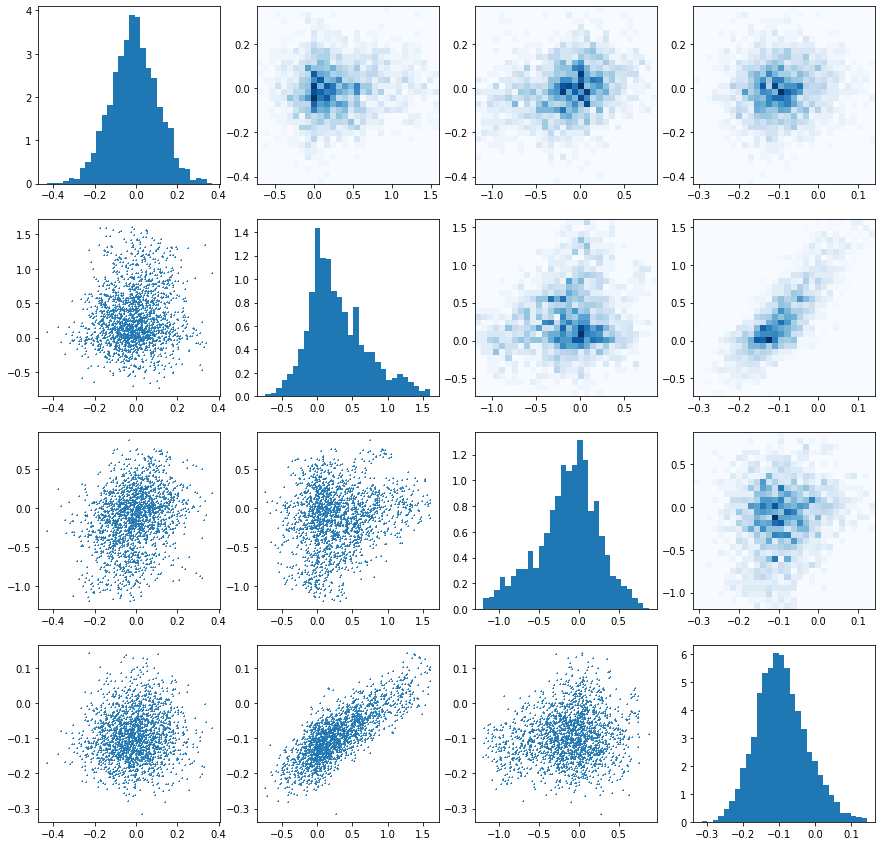

In [10]:
# plot parameters spread
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
for i in range(4):
    axs[i, i].hist(parameters[:, i], bins=30, density=True)
    for j in range(i):
        axs[i, j].scatter(parameters[:, j], parameters[:, i], s=1, marker="+")
    for j in range(i + 1, 4):
        axs[i, j].hist2d(parameters[:, j], parameters[:, i], bins=30, cmap="Blues")
plt.show()